In [179]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForTokenClassification, AutoModelForSequenceClassification
from transformers import pipeline
from scipy.special import softmax
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [166]:
def read_data(filename):
    sentences = []

    # Open the file in read mode
    with open(filename, 'r') as file:
        # Read each line in the file
        for line in file:
            # Strip leading/trailing whitespaces
            line = line.strip()
            # If the line is not empty, split it into sentences and add them to the list
            if line:
                # Split the line into sentences based on common delimiters like '.', '!', '?'
                line_sentences = [s.strip() for s in line.split('.') if s.strip()]
                # Extend the list of sentences
                sentences.extend(line_sentences)

    return sentences

In [167]:
filename = 'data.txt'
sentences = read_data(filename)

In [168]:
sentences

['Stocks of Yes Bank are on the rise',
 'It is expected to perform well this quarter',
 'Google stocks dipped down slighly',
 'It is expected to improve later',
 'I was quite surprising',
 'Yes Bank stocks jumped up by 25%',
 'I was quite disappointing a bit',
 'The sudden down trend of Google stocks',
 'my name is albin johns',
 'Yes Bank is on rise by 36%',
 'Tesla Inc ceo says Doge Coin is the future',
 'Tesla Inc stock price about to soar',
 'Apple Inc stocks had a sudden dip',
 'Apple Inc on a downtrend',
 'Zerodha is projected to rise',
 'Audi is expected a sudden downtrend',
 'Bloomberg Inc had a stock increase']

Passing list into NER Classifier

In [169]:
tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")
model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [170]:
nlp = pipeline("ner", model=model, tokenizer=tokenizer)

In [171]:
def extract_organization_examples(examples):
    organization_examples_dict = {}

    for example in examples:
        ner_results = nlp(example)
        organization_name = ""
        for result in ner_results:
            if result['entity'] == 'B-ORG':
                organization_name += result['word']
            elif result['entity'] == 'I-ORG':
                organization_name += result['word'].replace("##", "")

        if organization_name:
            if organization_name not in organization_examples_dict:
                organization_examples_dict[organization_name] = [example]
            else:
                organization_examples_dict[organization_name].append(example)

    return organization_examples_dict


In [172]:
organization_examples = extract_organization_examples(sentences)
print(organization_examples)


{'YesBank': ['Stocks of Yes Bank are on the rise', 'Yes Bank stocks jumped up by 25%', 'Yes Bank is on rise by 36%'], 'Google': ['Google stocks dipped down slighly', 'The sudden down trend of Google stocks'], 'TeslaInc': ['Tesla Inc ceo says Doge Coin is the future', 'Tesla Inc stock price about to soar'], 'AppleInc': ['Apple Inc stocks had a sudden dip', 'Apple Inc on a downtrend'], 'Zerodha': ['Zerodha is projected to rise'], 'Audi': ['Audi is expected a sudden downtrend'], 'BloombergInc': ['Bloomberg Inc had a stock increase']}


Sentiment analysis on the Companies

In [173]:
tokenizer = AutoTokenizer.from_pretrained("ahmedrachid/FinancialBERT-Sentiment-Analysis")
model = AutoModelForSequenceClassification.from_pretrained("ahmedrachid/FinancialBERT-Sentiment-Analysis")

In [174]:
def get_max_indices(sentences_dict, model, tokenizer):
    max_indices = {}
    for key, sentences in sentences_dict.items():
        scores_list = []
        for sentence in sentences:
            encoded_text = tokenizer(sentence, return_tensors='pt')
            output = model(**encoded_text)
            scores = output[0][0].detach().numpy()
            scores = softmax(scores)
            scores_list.append(np.argmax(scores))
        max_indices[key] = scores_list
    return max_indices

In [175]:
data = get_max_indices(organization_examples, model, tokenizer)
print(data)

{'YesBank': [1, 2, 2], 'Google': [0, 0], 'TeslaInc': [1, 2], 'AppleInc': [0, 1], 'Zerodha': [2], 'Audi': [0], 'BloombergInc': [2]}


negative sentiment = 0
neutral sentiment = 1
positive sentiment = 2
----------------------------Test from here on out--------------------

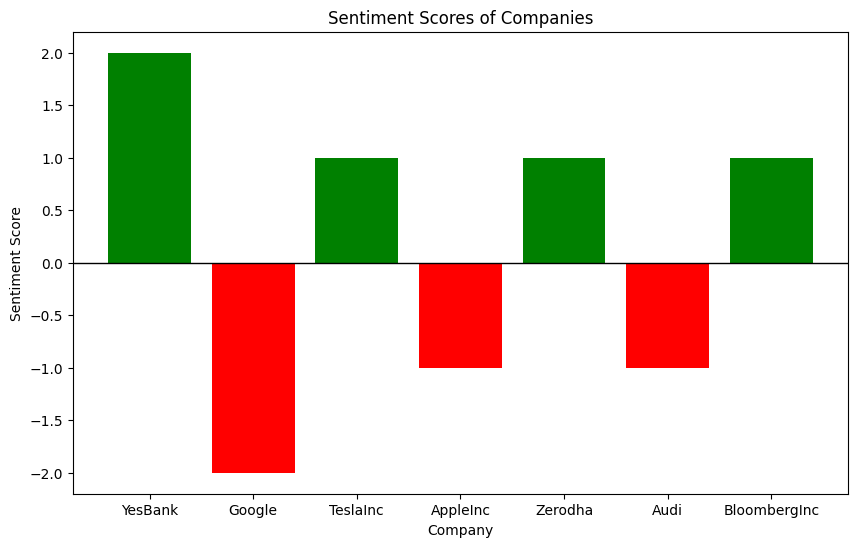

In [176]:
sentiment_scores = {}

for company, sentiments in data.items():
    score = 0
    for sentiment in sentiments:
        if sentiment == 2:
            score += 1
        elif sentiment == 0:
            score -= 1
    sentiment_scores[company] = score

# Extracting x and y data for plotting
companies = list(sentiment_scores.keys())
scores = list(sentiment_scores.values())

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(companies, scores, color=['green' if score >= 0 else 'red' for score in scores])
plt.xlabel('Company')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Scores of Companies')
plt.axhline(color='black', linewidth=1)  # Adding a horizontal line at y=0
plt.show()


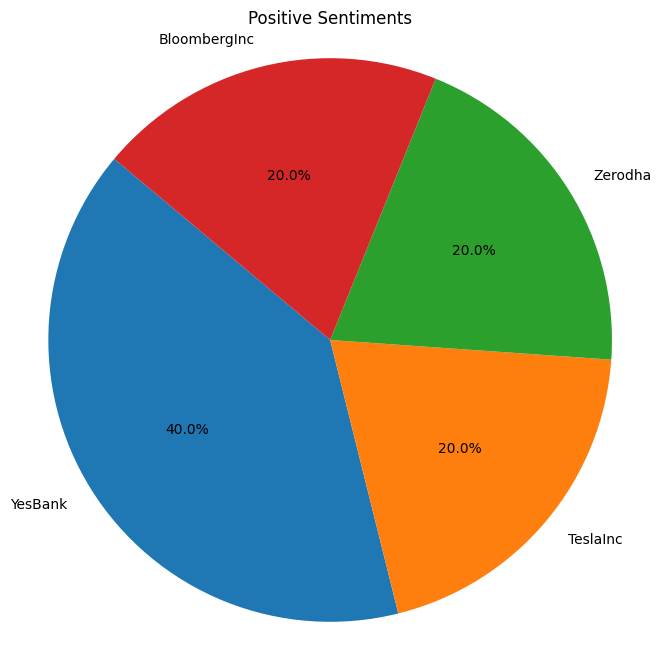

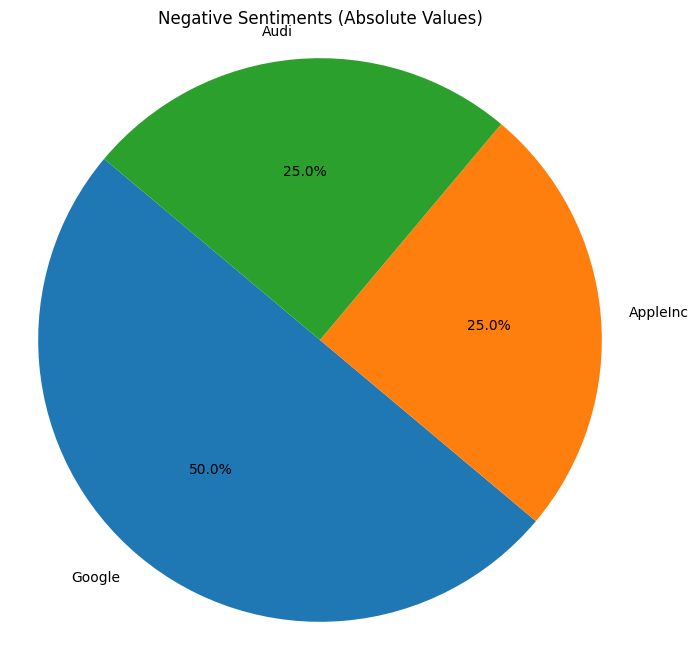

In [177]:
positive_sentiments = {company: score for company, score in sentiment_scores.items() if score > 0}
negative_sentiments = {company: abs(score) for company, score in sentiment_scores.items() if score < 0}

# Pie chart for positive sentiments
plt.figure(figsize=(8, 8))
plt.pie(positive_sentiments.values(), labels=positive_sentiments.keys(), autopct='%1.1f%%', startangle=140)
plt.title('Positive Sentiments')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

# Pie chart for negative sentiments (converted to non-negative values)
plt.figure(figsize=(8, 8))
plt.pie(negative_sentiments.values(), labels=negative_sentiments.keys(), autopct='%1.1f%%', startangle=140)
plt.title('Negative Sentiments (Absolute Values)')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

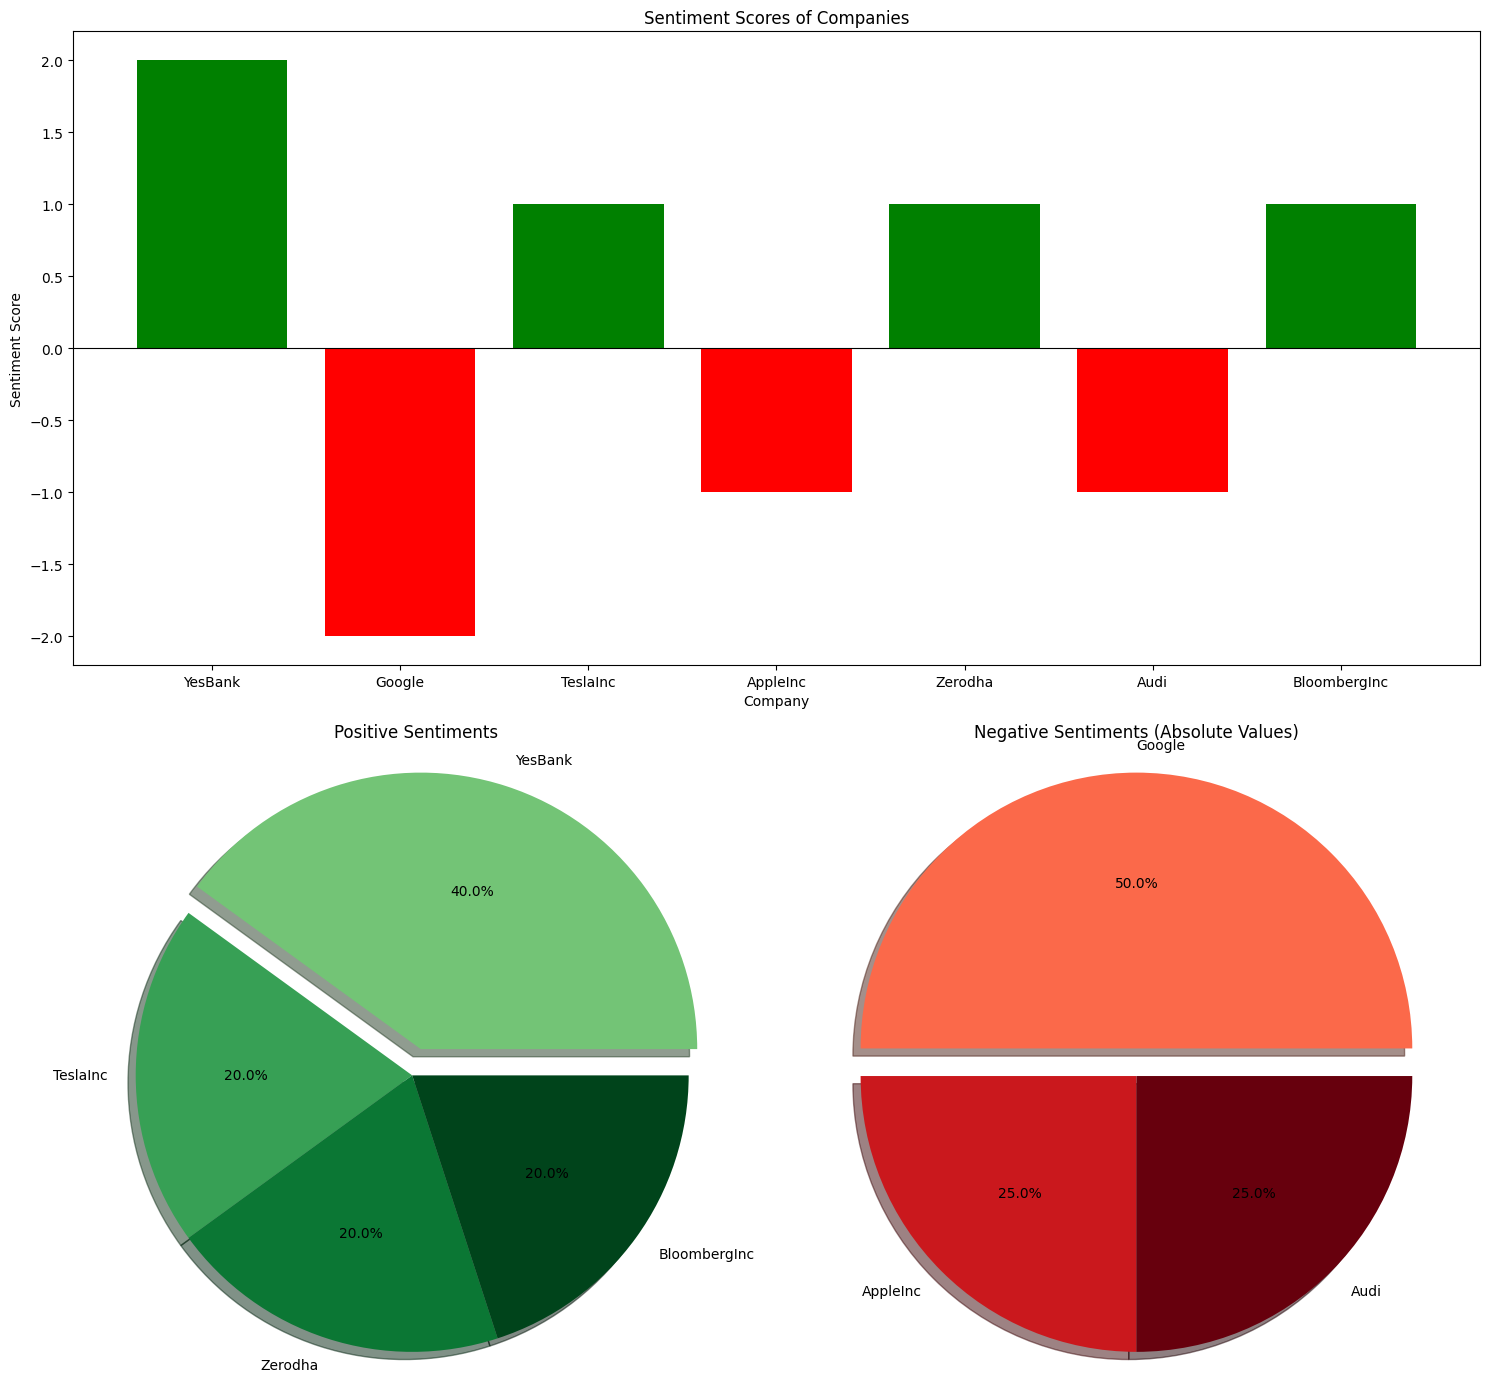

In [181]:
# Plotting the bar chart
plt.figure(figsize=(15, 14))

plt.subplot(2, 1, 1)
plt.bar(companies, scores, color=['green' if score >= 0 else 'red' for score in scores])
plt.xlabel('Company')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Scores of Companies')
plt.axhline(color='black', linewidth=0.8)  # Adding a horizontal line at y=0

# Finding the index of the highest value in the positive sentiment scores
max_positive_index = list(positive_sentiments.values()).index(max(positive_sentiments.values()))

# Finding the index of the highest value in the negative sentiment scores
max_negative_index = list(negative_sentiments.values()).index(max(negative_sentiments.values()))

# Colors for positive sentiment pie chart
positive_colors = cm.Greens(np.linspace(0.5, 1, len(positive_sentiments)))

# Pie chart for positive sentiments
plt.subplot(2, 2, 3)
explode_pos = [0] * len(positive_sentiments)
explode_pos[max_positive_index] = 0.1  # Explode the highest value
plt.pie(positive_sentiments.values(), labels=positive_sentiments.keys(), autopct='%1.1f%%', explode=explode_pos, colors=positive_colors, shadow=True)
plt.title('Positive Sentiments')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

# Colors for negative sentiment pie chart
negative_colors = cm.Reds(np.linspace(0.5, 1, len(negative_sentiments)))

# Pie chart for negative sentiments (converted to non-negative values)
plt.subplot(2, 2, 4)
explode_neg = [0] * len(negative_sentiments)
explode_neg[max_negative_index] = 0.1  # Explode the highest value
plt.pie(negative_sentiments.values(), labels=negative_sentiments.keys(), autopct='%1.1f%%', explode=explode_neg, colors=negative_colors, shadow=True)
plt.title('Negative Sentiments (Absolute Values)')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

plt.tight_layout()
plt.show()